In [43]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [44]:
data_path = '../data'

os.listdir(data_path)

['2024_tourney_seeds.csv',
 'Cities.csv',
 'Conferences.csv',
 'MConferenceTourneyGames.csv',
 'MGameCities.csv',
 'MMasseyOrdinals.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneyDetailedResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MNCAATourneySlots.csv',
 'MRegularSeasonCompactResults.csv',
 'MRegularSeasonDetailedResults.csv',
 'MSeasons.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamCoaches.csv',
 'MTeamConferences.csv',
 'MTeams.csv',
 'MTeamSpellings.csv',
 'sample_submission.csv',
 'WGameCities.csv',
 'WNCAATourneyCompactResults.csv',
 'WNCAATourneyDetailedResults.csv',
 'WNCAATourneySeeds.csv',
 'WNCAATourneySlots.csv',
 'WRegularSeasonCompactResults.csv',
 'WRegularSeasonDetailedResults.csv',
 'WSeasons.csv',
 'WTeamConferences.csv',
 'WTeams.csv',
 'WTeamSpellings.csv']

In [45]:
seeds = pd.read_csv("../data/MNCAATourneySeeds.csv").assign(League="M").reset_index(drop=True)

season_results = pd.read_csv("../data/MRegularSeasonDetailedResults.csv").assign(League="M").reset_index(drop=True)

tourney_results = pd.read_csv("../data/MNCAATourneyDetailedResults.csv").assign(League="M").reset_index(drop=True)

teams = pd.read_csv("../data/MTeams.csv")[['TeamID','TeamName']]

seeds_2024 = pd.read_csv("../data/2024_tourney_seeds.csv")

In [46]:
seeds.head()

,Season,Seed,TeamID,League
0,1985,W01,1207,M
1,1985,W02,1210,M
2,1985,W03,1228,M
3,1985,W04,1260,M
4,1985,W05,1374,M


In [47]:
season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,League
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,M
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,M
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,M
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,M
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,M


In [48]:
season_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'League'],
      dtype='object')

In [49]:
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,League
0,2003,134,1421,92,1411,84,N,1,32,69,...,14,31,17,28,16,15,5,0,22,M
1,2003,136,1112,80,1436,51,N,0,31,66,...,7,7,8,26,12,17,10,3,15,M
2,2003,136,1113,84,1272,71,N,0,31,59,...,14,21,20,22,11,12,2,5,18,M
3,2003,136,1141,79,1166,73,N,0,29,53,...,12,17,14,17,20,21,6,6,21,M
4,2003,136,1143,76,1301,74,N,1,27,64,...,15,20,10,26,16,14,5,8,19,M


In [50]:
# metrics of Wins and Losses
team_results = pd.concat(
[season_results[["Season", "League","DayNum", "WTeamID", "WScore", "LScore"]].assign(GameResult="W")
.rename(columns={"WTeamID": "TeamID", "WScore": "TeamScore", "LScore": "OppScore"}),
    
season_results[["Season", "League","DayNum", "LTeamID", "WScore", "LScore"]].assign(GameResult="L")
.rename(columns={"LTeamID": "TeamID", "LScore": "TeamScore", "WScore": "OppScore"}),
]
).reset_index(drop=True)

In [51]:
team_results.sample(10, random_state=99)

,Season,League,DayNum,TeamID,TeamScore,OppScore,GameResult
86178,2019,M,101,1410,59,44,W
169175,2014,M,41,1461,61,64,L
168951,2014,M,33,1420,68,70,L
185902,2017,M,61,1223,51,61,L
96480,2021,M,124,1455,80,63,W
104123,2023,M,59,1158,89,61,W
177714,2015,M,116,1156,53,56,L
34394,2010,M,16,1428,68,67,W
142879,2009,M,47,1253,61,75,L
115696,2003,M,96,1225,44,52,L


In [52]:
# double checking if '24 season is there
season_24 = (team_results['Season'] == 2024).any()
season_24

True

In [53]:
# Score Diff
team_results["ScoreDiff"] = (team_results["TeamScore"] - team_results["OppScore"])

In [54]:
team_results.sample(10, random_state=99)

,Season,League,DayNum,TeamID,TeamScore,OppScore,GameResult,ScoreDiff
86178,2019,M,101,1410,59,44,W,15
169175,2014,M,41,1461,61,64,L,-3
168951,2014,M,33,1420,68,70,L,-2
185902,2017,M,61,1223,51,61,L,-10
96480,2021,M,124,1455,80,63,W,17
104123,2023,M,59,1158,89,61,W,28
177714,2015,M,116,1156,53,56,L,-3
34394,2010,M,16,1428,68,67,W,1
142879,2009,M,47,1253,61,75,L,-14
115696,2003,M,96,1225,44,52,L,-8


In [55]:
# wins and losses
# unstack() "pivots a level of the index labels"
# merging teams / need TeamName
# using groupby of TeamNames of their Ws and Ls

team_performance = team_results.groupby(['Season','TeamID','GameResult']).size().unstack(fill_value=0)
team_performance = team_performance[['W','L']]
team_performance = team_performance.merge(teams,on='TeamID')
team_performance = team_performance.groupby('TeamName').agg({'W':'sum','L':'sum'}).reset_index()
team_performance

,TeamName,W,L
0,Abilene Chr,136,152
1,Air Force,282,352
2,Akron,440,235
3,Alabama,417,270
4,Alabama A&M,189,406
...,...,...,...
364,Wright St,382,285
365,Wyoming,310,342
366,Xavier,473,219
367,Yale,323,255


C:\Users\Michael\AppData\Local\Temp\ipykernel_4660\2849246325.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top_wins['TeamName'], rotation=45)
C:\Users\Michael\AppData\Local\Temp\ipykernel_4660\2849246325.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top_losses['TeamName'], rotation=45)


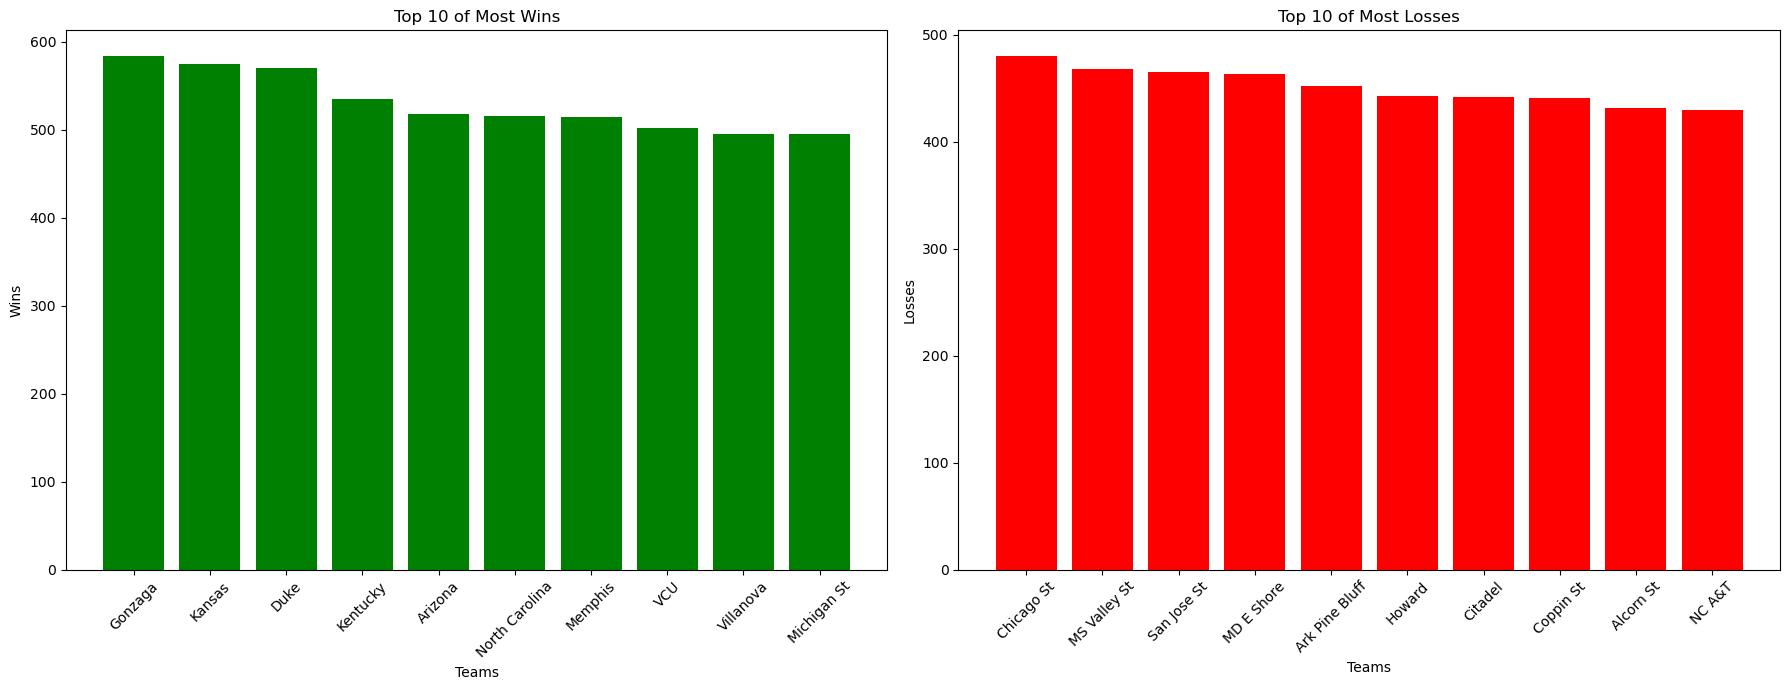

In [56]:
# Top 10 Wins and Losses

top_wins = team_performance.sort_values(by='W', ascending=False).head(10)
top_losses = team_performance.sort_values(by='L', ascending=False).head(10)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
# Top 10 Wins
axes[0].bar(top_wins['TeamName'], top_wins['W'], color='green')
axes[0].set_title('Top 10 of Most Wins')
axes[0].set_xticklabels(top_wins['TeamName'], rotation=45)
axes[0].set_ylabel('Wins')
axes[0].set_xlabel('Teams')

# Top 10 Losses
axes[1].bar(top_losses['TeamName'], top_losses['L'], color='red')
axes[1].set_title('Top 10 of Most Losses')
axes[1].set_xticklabels(top_losses['TeamName'], rotation=45)
axes[1].set_ylabel('Losses')
axes[1].set_xlabel('Teams')

plt.tight_layout()
plt.show()

In [57]:
team_results

,Season,League,DayNum,TeamID,TeamScore,OppScore,GameResult,ScoreDiff
0,2003,M,10,1104,68,62,W,6
1,2003,M,10,1272,70,63,W,7
2,2003,M,11,1266,73,61,W,12
3,2003,M,11,1296,56,50,W,6
4,2003,M,11,1400,77,71,W,6
...,...,...,...,...,...,...,...,...
225003,2024,M,114,1237,70,75,L,-5
225004,2024,M,114,1412,66,74,L,-8
225005,2024,M,114,1359,69,91,L,-22
225006,2024,M,114,1177,58,91,L,-33


In [58]:
# 2024 Season 
season_24 = team_results[team_results['Season'] == 2024]
season_24 = season_24.groupby(['Season','TeamID','GameResult']).size().unstack(fill_value=0)
season_24 = season_24[['W','L']]
season_24 = season_24.merge(teams,on='TeamID')

season_24.groupby('TeamName').agg({'W': 'sum', 'L': 'sum'}).reset_index()
top_wins_2024 = season_24.sort_values(by='W', ascending=False).head(10)
top_losses_2024 = season_24.sort_values(by='L', ascending=False).head(10)

top_wins_2024 = top_wins_2024[['TeamName','W','L']]
top_wins_2024


,TeamName,W,L
132,James Madison,26,3
56,Connecticut,25,3
113,Houston,25,3
233,Purdue,25,3
123,Indiana St,24,5
72,Drake,23,6
247,Samford,23,5
9,Appalachian St,23,5
263,South Carolina,23,5
106,Grand Canyon,23,4


C:\Users\Michael\AppData\Local\Temp\ipykernel_4660\3514031419.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_wins_2024['TeamName'], rotation=45, ha="right")


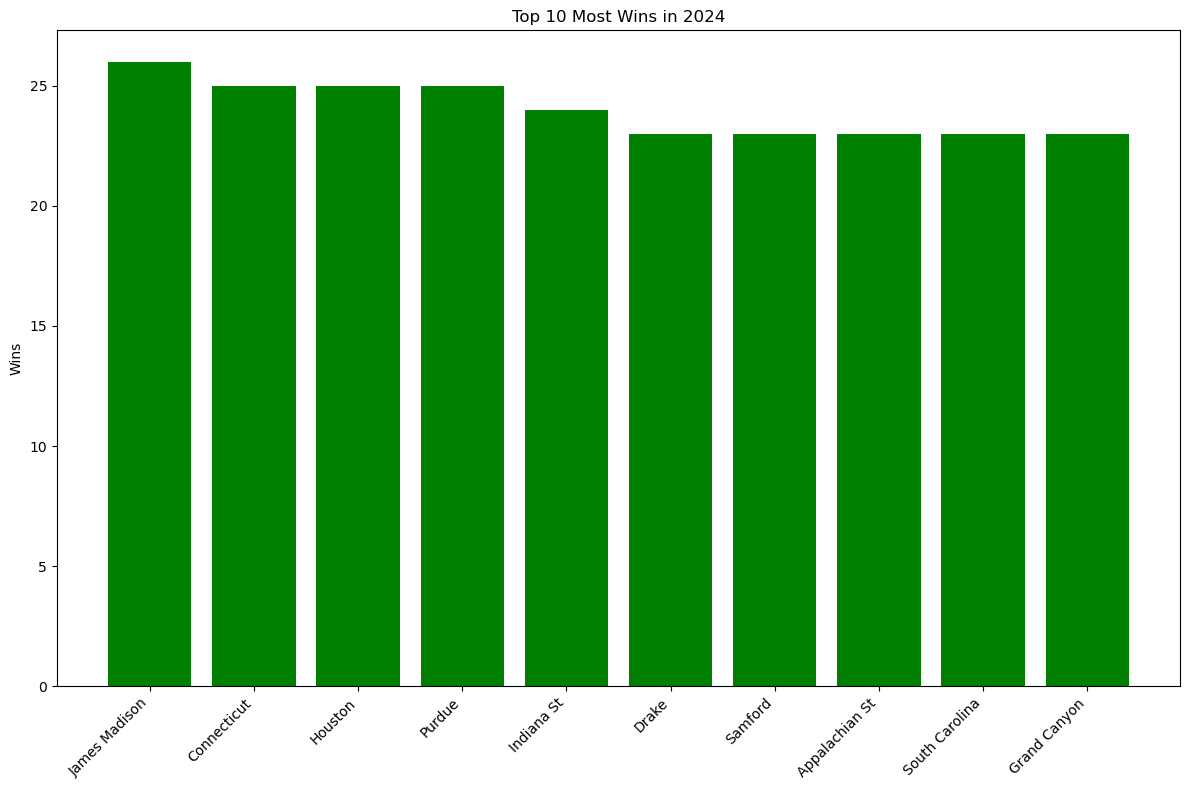

In [59]:
# 2024 Season Top 10 wins 

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(top_wins_2024['TeamName'], top_wins_2024['W'], color='green')
ax.set_ylabel('Wins')
ax.set_title('Top 10 Most Wins in 2024')
ax.set_xticklabels(top_wins_2024['TeamName'], rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [60]:
# chalk and regions of the Men League
team_map = teams.set_index('TeamID')['TeamName']
seeds_2024['TeamName'] = seeds_2024['TeamID'].map(team_map)
seeds_2024 = seeds_2024[seeds_2024['Tournament'] == 'M']
seeds_2024['Region'] = seeds_2024['Seed'].str[0]
seeds_2024['Chalk_Seed'] = seeds_2024['Seed'].str[1:].astype('int')
seeds_2024[['Tournament','Region']].value_counts()

Tournament  Region
M           W         16
            X         16
            Y         16
            Z         16
Name: count, dtype: int64

In [61]:
seeds_2024 = seeds_2024[['TeamName','Chalk_Seed','Region']]
seeds_2024

,TeamName,Chalk_Seed,Region
0,Connecticut,1,W
1,Iowa St,2,W
2,Illinois,3,W
3,Auburn,4,W
4,San Diego St,5,W
...,...,...,...
59,James Madison,12,Z
60,Vermont,13,Z
61,Oakland,14,Z
62,WKU,15,Z


In [62]:
seeds_2024.query('Chalk_Seed == 1')

,TeamName,Chalk_Seed,Region
0,Connecticut,1,W
16,North Carolina,1,X
32,Purdue,1,Y
48,Houston,1,Z


![True Shooting Percentage.jpg](<attachment:True Shooting Percentage.jpg>)
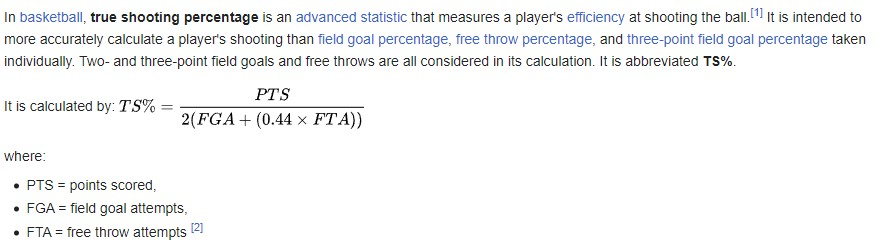

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)

![Total Points Calculations.jpg](<attachment:Total Points Calculations.jpg>)
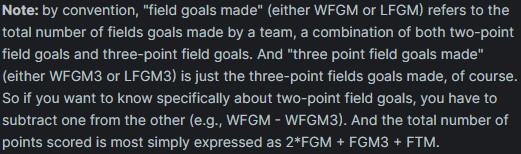

In [63]:
# total points
season_results['WTotalPoints'] = 2 * season_results['WFGM'] + season_results['WFTM'] + season_results['WFGM3']
season_results['LTotalPoints'] = 2 * season_results['LFGM'] + season_results['LFTM'] + season_results['LFGM3']

In [64]:
# True Shooting Percentage (TS%)
season_results['W_TS%'] = season_results['WTotalPoints'] / (2 * (season_results['WFGA'] + 0.44 * season_results['WFTA']))
season_results['L_TS%'] = season_results['LTotalPoints'] / (2 * (season_results['LFGA'] + 0.44 * season_results['LFTA']))

In [65]:
season_results[['Season','DayNum','WTeamID','W_TS%','LTeamID','L_TS%']]

,Season,DayNum,WTeamID,W_TS%,LTeamID,L_TS%
0,2003,10,1104,0.515777,1328,0.494576
1,2003,10,1272,0.497442,1393,0.415567
2,2003,11,1266,0.515828,1437,0.366939
3,2003,11,1296,0.542215,1457,0.449640
4,2003,11,1400,0.577038,1208,0.480509
...,...,...,...,...,...,...
112499,2024,114,1454,0.547925,1237,0.492126
112500,2024,114,1455,0.606160,1412,0.494901
112501,2024,114,1459,0.671091,1359,0.512478
112502,2024,114,1462,0.621925,1177,0.507348


![Effective Field Goal Percentage.jpg](<attachment:Effective Field Goal Percentage.jpg>)
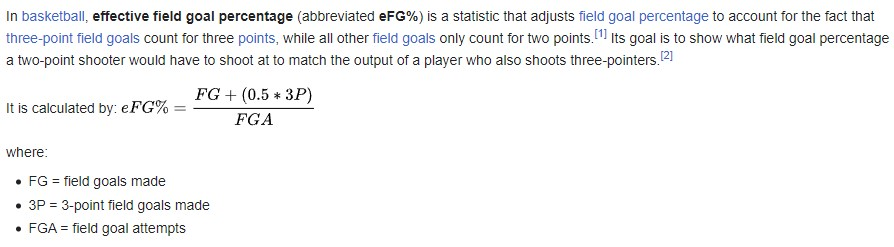

In [66]:
# Effective Field Goal Percentage = eFG%
# eFG% for the winning team
season_results['WeFG%'] = (season_results['WFGM'] + 0.5 * season_results['WFGM3']) / season_results['WFGA']

# eFG% for the losing team
season_results['LeFG%'] = (season_results['LFGM'] + 0.5 * season_results['LFGM3']) / season_results['LFGA']

In [67]:
season_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'League', 'WTotalPoints', 'LTotalPoints', 'W_TS%', 'L_TS%', 'WeFG%',
       'LeFG%'],
      dtype='object')

In [68]:
# Score Diff
season_results["ScoreDiff"] = (season_results["WScore"] - season_results["LScore"])

In [69]:
season_results['TS%_Diff'] = season_results['W_TS%'] - season_results['L_TS%']
season_results['eFG%_Diff'] = season_results['WeFG%'] - season_results['LeFG%']

In [70]:
# Features to use
# True Shooting Percentage Diff (TS%_Diff)
# Effective Field Goal Percentage Diff (eFG%_Diff)

season_results = season_results[['Season','League','DayNum','WTeamID','LTeamID','ScoreDiff','TS%_Diff','eFG%_Diff']]
season_results

,Season,League,DayNum,WTeamID,LTeamID,ScoreDiff,TS%_Diff,eFG%_Diff
0,2003,M,10,1104,1328,6,0.021201,0.057417
1,2003,M,10,1272,1393,7,0.081874,0.080886
2,2003,M,11,1266,1437,12,0.148889,0.160841
3,2003,M,11,1296,1457,6,0.092575,0.084586
4,2003,M,11,1400,1208,6,0.096529,0.105500
...,...,...,...,...,...,...,...,...
112499,2024,M,114,1454,1237,5,0.055799,0.022289
112500,2024,M,114,1455,1412,8,0.111259,0.126706
112501,2024,M,114,1459,1359,22,0.158614,0.232512
112502,2024,M,114,1462,1177,33,0.114577,0.143693


In [71]:
# amount of wins and losses
wins = season_results.groupby(['Season','WTeamID']).size().reset_index(name='Wins').rename(columns = {'WTeamID': 'TeamID'})
losses = season_results.groupby(['Season','LTeamID']).size().reset_index(name='Losses').rename(columns = {'LTeamID': 'TeamID'})
performance = pd.merge(wins, losses, on=['Season','TeamID'], how='outer').fillna(0)

# margin win and losses
margin_win = season_results.groupby(['Season','WTeamID'])['ScoreDiff'].mean().reset_index(name='AvgWinScoreDiff')
margin_loss = season_results.groupby(['Season','LTeamID'])['ScoreDiff'].agg(lambda x: -x.mean()).reset_index(name='AvgLossScoreDiff')
margin_win = margin_win.rename(columns={'WTeamID': 'TeamID'})
margin_loss = margin_loss.rename(columns={'LTeamID': 'TeamID'})

performance

,Season,TeamID,Wins,Losses
0,2003,1102,12.0,16.0
1,2003,1103,13.0,14.0
2,2003,1104,17.0,11.0
3,2003,1105,7.0,19.0
4,2003,1106,13.0,15.0
...,...,...,...,...
7612,2015,1212,0.0,27.0
7613,2015,1363,0.0,28.0
7614,2021,1152,0.0,9.0
7615,2022,1175,0.0,25.0


In [72]:
# checking for 2024 games
# performance_24 = (performance['Season'] == 2024).any()
# performance_24

In [73]:
performance_win = pd.merge(wins, margin_win, on=['Season', 'TeamID'], how='left')
performance_loss = pd.merge(losses, margin_loss, on=['Season', 'TeamID'], how='left')

performance= pd.merge(performance_win, performance_loss, on=['Season', 'TeamID'], how='left').fillna(0)

performance

,Season,TeamID,Wins,AvgWinScoreDiff,Losses,AvgLossScoreDiff
0,2003,1102,12,15.583333,16.0,-11.250000
1,2003,1103,13,9.384615,14.0,-7.500000
2,2003,1104,17,13.176471,11.0,-9.454545
3,2003,1105,7,13.000000,19.0,-11.473684
4,2003,1106,13,10.384615,15.0,-9.266667
...,...,...,...,...,...,...
7604,2024,1474,10,8.900000,18.0,-14.166667
7605,2024,1475,5,8.000000,21.0,-11.952381
7606,2024,1476,3,10.666667,25.0,-16.480000
7607,2024,1477,7,6.714286,18.0,-17.222222


In [74]:
# Win/Loss ratio
# Overall Score Diff Averages
performance['WinLossRatio'] = performance['Wins'] / (performance['Losses'] + 1)
performance['AvgScoreDiff'] = (performance['AvgWinScoreDiff'] * performance['Wins'] + performance['AvgLossScoreDiff'] * performance['Losses']) / (performance['Wins'] + performance['Losses'])

performance

,Season,TeamID,Wins,AvgWinScoreDiff,Losses,AvgLossScoreDiff,WinLossRatio,AvgScoreDiff
0,2003,1102,12,15.583333,16.0,-11.250000,0.705882,0.250000
1,2003,1103,13,9.384615,14.0,-7.500000,0.866667,0.629630
2,2003,1104,17,13.176471,11.0,-9.454545,1.416667,4.285714
3,2003,1105,7,13.000000,19.0,-11.473684,0.350000,-4.884615
4,2003,1106,13,10.384615,15.0,-9.266667,0.812500,-0.142857
...,...,...,...,...,...,...,...,...
7604,2024,1474,10,8.900000,18.0,-14.166667,0.526316,-5.928571
7605,2024,1475,5,8.000000,21.0,-11.952381,0.227273,-8.115385
7606,2024,1476,3,10.666667,25.0,-16.480000,0.115385,-13.571429
7607,2024,1477,7,6.714286,18.0,-17.222222,0.368421,-10.520000


In [75]:
df = pd.merge(season_results, performance.add_suffix('_W'),  # suffix for winning team's performance
    left_on=['Season', 'WTeamID'],
    right_on=['Season_W', 'TeamID_W'],
    how='left'
)

df = pd.merge(
    df, performance.add_suffix('_L'),  # suffix for losing team's performance
    left_on=['Season', 'LTeamID'],
    right_on=['Season_L', 'TeamID_L'],
    how='left'
)

In [76]:
df['WinLossRatioDiff'] = df['WinLossRatio_W'] - df['WinLossRatio_L']
df['AvgScoreDiff'] = df['AvgScoreDiff_W'] - df['AvgScoreDiff_L']
df

,Season,League,DayNum,WTeamID,LTeamID,ScoreDiff,TS%_Diff,eFG%_Diff,Season_W,TeamID_W,...,Season_L,TeamID_L,Wins_L,AvgWinScoreDiff_L,Losses_L,AvgLossScoreDiff_L,WinLossRatio_L,AvgScoreDiff_L,WinLossRatioDiff,AvgScoreDiff
0,2003,M,10,1104,1328,6,0.021201,0.057417,2003,1104,...,2003.0,1328.0,24.0,15.541667,6.0,-7.166667,3.428571,11.000000,-2.011905,-6.714286
1,2003,M,10,1272,1393,7,0.081874,0.080886,2003,1272,...,2003.0,1393.0,24.0,14.416667,5.0,-10.000000,4.000000,10.206897,-0.714286,-1.517241
2,2003,M,11,1266,1437,12,0.148889,0.160841,2003,1266,...,2003.0,1437.0,15.0,12.266667,15.0,-8.066667,0.937500,2.100000,2.895833,8.614286
3,2003,M,11,1296,1457,6,0.092575,0.084586,2003,1296,...,2003.0,1457.0,18.0,10.833333,10.0,-11.000000,1.636364,3.035714,-0.503030,-3.229263
4,2003,M,11,1400,1208,6,0.096529,0.105500,2003,1400,...,2003.0,1208.0,19.0,11.421053,8.0,-6.875000,2.111111,6.000000,1.031746,4.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112499,2024,M,114,1454,1237,5,0.055799,0.022289,2024,1454,...,2024.0,1237.0,3.0,9.333333,24.0,-20.166667,0.120000,-16.888889,0.813333,14.960317
112500,2024,M,114,1455,1412,8,0.111259,0.126706,2024,1455,...,2024.0,1412.0,17.0,5.882353,10.0,-9.900000,1.545455,0.037037,-0.934343,-1.858466
112501,2024,M,114,1459,1359,22,0.158614,0.232512,2024,1459,...,2024.0,1359.0,23.0,16.478261,5.0,-19.800000,3.833333,10.000000,-2.966667,-12.222222
112502,2024,M,114,1462,1177,33,0.114577,0.143693,2024,1462,...,2024.0,1177.0,3.0,10.333333,25.0,-20.200000,0.115385,-16.928571,0.817949,19.535714


In [77]:
new_df = df.copy()
# flipping the data gives the model examples to learn from  
# inverted data frame where the perspective is flipped (loser-winner)
df_inverted = df.copy()
# invert the difference
df_inverted['WinLossRatioDiff'] = -df['WinLossRatioDiff'] 
df_inverted['AvgScoreDiff'] = -df['AvgScoreDiff']  
df_inverted['Outcome'] = 0  # since this perspective is from the losing side

# adding the Outcome column to the original df, set to 1 since it's from the winner's perspective
new_df['Outcome'] = 1

# combine the original and inverted data frames
df = pd.concat([new_df, df_inverted], ignore_index=True)
df

,Season,League,DayNum,WTeamID,LTeamID,ScoreDiff,TS%_Diff,eFG%_Diff,Season_W,TeamID_W,...,TeamID_L,Wins_L,AvgWinScoreDiff_L,Losses_L,AvgLossScoreDiff_L,WinLossRatio_L,AvgScoreDiff_L,WinLossRatioDiff,AvgScoreDiff,Outcome
0,2003,M,10,1104,1328,6,0.021201,0.057417,2003,1104,...,1328.0,24.0,15.541667,6.0,-7.166667,3.428571,11.000000,-2.011905,-6.714286,1
1,2003,M,10,1272,1393,7,0.081874,0.080886,2003,1272,...,1393.0,24.0,14.416667,5.0,-10.000000,4.000000,10.206897,-0.714286,-1.517241,1
2,2003,M,11,1266,1437,12,0.148889,0.160841,2003,1266,...,1437.0,15.0,12.266667,15.0,-8.066667,0.937500,2.100000,2.895833,8.614286,1
3,2003,M,11,1296,1457,6,0.092575,0.084586,2003,1296,...,1457.0,18.0,10.833333,10.0,-11.000000,1.636364,3.035714,-0.503030,-3.229263,1
4,2003,M,11,1400,1208,6,0.096529,0.105500,2003,1400,...,1208.0,19.0,11.421053,8.0,-6.875000,2.111111,6.000000,1.031746,4.178571,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225003,2024,M,114,1454,1237,5,0.055799,0.022289,2024,1454,...,1237.0,3.0,9.333333,24.0,-20.166667,0.120000,-16.888889,-0.813333,-14.960317,0
225004,2024,M,114,1455,1412,8,0.111259,0.126706,2024,1455,...,1412.0,17.0,5.882353,10.0,-9.900000,1.545455,0.037037,0.934343,1.858466,0
225005,2024,M,114,1459,1359,22,0.158614,0.232512,2024,1459,...,1359.0,23.0,16.478261,5.0,-19.800000,3.833333,10.000000,2.966667,12.222222,0
225006,2024,M,114,1462,1177,33,0.114577,0.143693,2024,1462,...,1177.0,3.0,10.333333,25.0,-20.200000,0.115385,-16.928571,-0.817949,-19.535714,0


In [78]:
df.columns

Index(['Season', 'League', 'DayNum', 'WTeamID', 'LTeamID', 'ScoreDiff',
       'TS%_Diff', 'eFG%_Diff', 'Season_W', 'TeamID_W', 'Wins_W',
       'AvgWinScoreDiff_W', 'Losses_W', 'AvgLossScoreDiff_W', 'WinLossRatio_W',
       'AvgScoreDiff_W', 'Season_L', 'TeamID_L', 'Wins_L', 'AvgWinScoreDiff_L',
       'Losses_L', 'AvgLossScoreDiff_L', 'WinLossRatio_L', 'AvgScoreDiff_L',
       'WinLossRatioDiff', 'AvgScoreDiff', 'Outcome'],
      dtype='object')

In [79]:
features = [
    'DayNum', 'TS%_Diff', 'eFG%_Diff',
    'WinLossRatio_W', 'WinLossRatio_L',
    'AvgScoreDiff_W', 'AvgScoreDiff_L',
    'WinLossRatioDiff', 'AvgScoreDiff'
    ]

In [80]:
# have NaN values / don't know why
df = df.dropna(subset=features)

In [81]:
# X = df[features]
# y = df['Outcome']

X = df[['WinLossRatioDiff', 'AvgScoreDiff']]
y = df['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# predictions and evaluation
rf_predictions = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.6674


In [82]:
# Log Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# predictions and evaluation
log_predictions = log_reg.predict(X_test)
log_accuracy = accuracy_score(y_test, log_predictions)
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")

Logistic Regression Accuracy: 0.7321


In [83]:
# XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# predictions and evaluation
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.7356


In [84]:
# using another Kaggle submission as reference
xgb = XGBRegressor(eval_metric="logloss",n_estimators=1_000,learning_rate=0.001)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Predict on the test set
y_pred = xgb.predict(X_test)
log_loss = log_loss(y_test, y_pred)
y_pred = y_pred > 0.5

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy} Log Loss:{log_loss}")



[0]	validation_0-logloss:0.69287
[100]	validation_0-logloss:0.66603
[200]	validation_0-logloss:0.64387
[300]	validation_0-logloss:0.62544
[400]	validation_0-logloss:0.61002
[500]	validation_0-logloss:0.59706
[600]	validation_0-logloss:0.58614
[700]	validation_0-logloss:0.57692
[800]	validation_0-logloss:0.56911
[900]	validation_0-logloss:0.56250
[999]	validation_0-logloss:0.55695
Accuracy:0.7371221227906148 Log Loss:0.5569460071339274
